# GAN with CelabA

### 1. Kaggle 데이터셋 다운로드

In [1]:
# kaggle.json 파일 업로드
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rabbiit","key":"76f08f89138f2ee6bc3daf682f163704"}'}

In [2]:
# kaggle api key 설정
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# kaggle 데이터셋 다운로드
!kaggle datasets download -d jessicali9530/celeba-dataset

# 압축 해제
!unzip -q celeba-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:11<00:00, 113MB/s] 
100% 1.33G/1.33G [00:11<00:00, 120MB/s]


### 2. 이미지 전처리

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

images = glob.glob('./img_align_celeba/img_align_celeba/*.jpg')
print(len(images))

202599


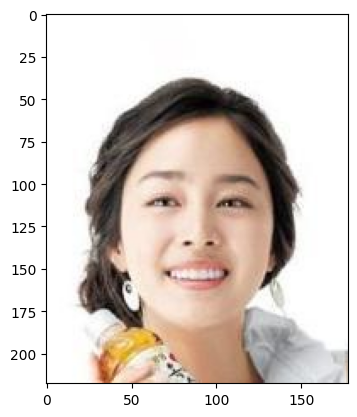

In [5]:
image = Image.open('./img_align_celeba/img_align_celeba/188076.jpg') #4501, 4614, 200045, 220, 564, 170321, 188076
plt.imshow(image)

In [6]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(root='./img_align_celeba/', transform=transform)

data_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

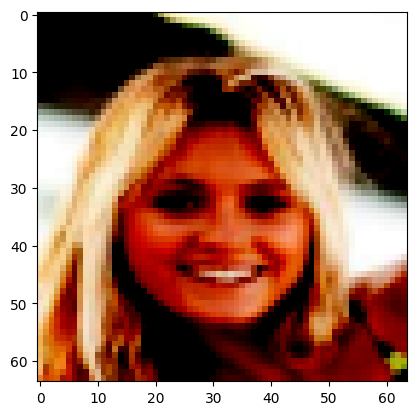

In [7]:
import numpy as np

iter_data = iter(data_loader)
img, label = next(iter(iter_data))

img = img[3].numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))

### 3. GAN 모델 구성

In [8]:
import torch.nn as nn

In [9]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.gen = nn.Sequential(
        nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )


  def forward(self, x):
    return self.gen(x)

In [10]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 1, kernel_size=4),
        nn.Sigmoid()
    )


  def forward(self, x):
    return self.disc(x)

### 4. 모델 학습

In [11]:
# 가중치 초기화 함수
def weights_init(m):
  classname = type(m).__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [12]:
import torch
import tqdm
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

G_optim = Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
# 학습 루프
for epoch in range(20):
  iterator = tqdm.tqdm(enumerate(data_loader), total=len(data_loader))

  for idx, data in iterator:
    D_optim.zero_grad()
    label = torch.ones_like(data[1], dtype=torch.float32).to(device)
    label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

    # 진짜 이미지를 1로 판별
    real = D(data[0].to(device))
    D_loss_real = nn.BCELoss()(torch.squeeze(real), label)
    D_loss_real.backward()

    # 가짜 이미지를 0으로 판별
    noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
    fake = G(noise)
    output = D(fake.detach())
    D_loss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
    D_loss_fake.backward()

    D_loss = D_loss_real + D_loss_fake
    D_optim.step()

    # Generator 학습
    G_optim.zero_grad()
    output = D(fake)
    G_loss = nn.BCELoss()(torch.squeeze(output), label)
    G_loss.backward()
    G_optim.step()

    iterator.set_description(f'Epoch: {epoch} | index: {idx} | D_loss {D_loss}, G_loss {G_loss}')

  torch.save(G.state_dict(), './generator.pt')
  torch.save(D.state_dict(), './discriminator.pt')

Epoch: 0 | index: 1205 | D_loss 1.310178279876709, G_loss 1.4713356494903564:  76%|███████▌  | 1206/1583 [05:57<01:46,  3.55it/s]

In [ ]:
with torch.no_grad():
  G.load_state_dict(torch.load('./generator.pt'))
  noise = torch.randn(1, 100, 1, 1).to(device)
  img = G(noise).squeeze()
  img = img.permute(1, 2, 0).cpu().numpy()
  plt.imshow(img)